In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque  
from mlagents_envs.environment import UnityEnvironment

### Create DDPG agent!

In [3]:
N_STATES  = 210  # 105+105
N_ACTIONS = 1  # 1 branch with 7 values, move forward/backward, rotate R/L, move R/L 
N_AGENTS = 3

In [4]:
BUFFER_SIZE = int(1e3) #int(1e5)        # replay buffer size
BATCH_SIZE =  32   #128              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 1e-4              # learning rate of the critic
WEIGHT_DECAY = 0.0            # L2 weight decay

In [5]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else: 
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


In [6]:
# load NN, reply buffer, and Agent class
%run "9. DDPG_NN_and_MemoryBuffer.ipynb"   
%run "9. DDPG_Agent.ipynb"       

In [7]:
agent = Agent(state_size=N_STATES, action_size=N_ACTIONS, num_agents=N_AGENTS, random_seed=0)

# Load previously saved NN. Skip this if train a new NN

In [9]:
agent.actor_local.load_state_dict(torch.load('ddpgActor.pth'))
agent.actor_target.load_state_dict(torch.load('ddpgActor.pth'))
agent.critic_local.load_state_dict(torch.load('ddpgCritic.pth'))
agent.critic_target.load_state_dict(torch.load('ddpgCritic.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Let's begin training!

In [ ]:
# define a function to convert action value [-1, 1] to index 0~6
def GenerateActionIndex(acts):
    result = []
    for AgentIdx in range(N_AGENTS):
        value = acts[AgentIdx][0]
        interval = 2/7
        lower = -1
        for i in range(7):  #action index 0~6
            upper = lower + (i+1)*interval
            if(value >= lower and value <= upper):
                result.append([i])
                break
            else:
                lower = upper
    return result

In [ ]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [ ]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

In [10]:
num_episodes= 500  #5000

In [ ]:
episode_scores = []            #historical scores
scores_average_window = 100    #Window size to calculate avg score    
solved_score = 8               #avg score required to consider finished

In [23]:
# loop from num_episodes
for i_episode in range(1, num_episodes+1):
    # reset the unity environment at the beginning of each episode
    env.reset()    

    # get initial state of the unity environment 
    DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
    s1 = DecisionSteps.obs[0]
    s2 = DecisionSteps.obs[1]
    states = np.concatenate((s1, s2), 1)
    
	# reset the training agent for new episode
    agent.reset()

    # set the initial episode score to zero.
    agent_scores = np.zeros(N_AGENTS)

    # Run the episode training loop;
    # At each loop step take an action as a function of the current state observations
    # Based on the resultant environmental state (next_state) and reward received update the Agents Actor and Critic networks
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    i = 1
    while (True):
        # determine actions for the unity agents from current sate
        actions = agent.act(states)

        # send the actions to the unity agents in the environment and receive resultant environment information
        ActionIdxArray = np.array(GenerateActionIndex(actions))
        env.set_actions(behaviorName, ActionIdxArray)
        env.step()

        # get next states
        NextDecisionSteps, NextTerminalSteps = env.get_steps(behaviorName)
        
        #if next decision step misses some agents, then exit episode loop, to begin new episode
        if(len(NextDecisionSteps)!= N_AGENTS): 
            break
        
        # else next decision step contains all agents
        s1 = NextDecisionSteps.obs[0]
        s2 = NextDecisionSteps.obs[1]
        next_states = np.concatenate((s1, s2), 1)
        
        dones = np.array([[0]]*N_AGENTS)
        for AgentID in  NextTerminalSteps.agent_id:
            dones[AgentID] = 1                
        
        rewards = NextDecisionSteps.reward
        
        #Send (S, A, R, S') info to the training agent for replay buffer (memory) and network updates
        agent.step(states, ActionIdxArray, rewards, next_states, dones)

        # set new states to current states for determining next actions
        states = next_states

        # Update episode score for each unity agent
        agent_scores += rewards

    # Add episode score to Scores and...
    # Calculate mean score over last 100 episodes 
    # Mean score is calculated over current episodes until i_episode > 100
    episode_scores.append(np.mean(agent_scores))
    average_score = np.mean(episode_scores[i_episode-min(i_episode,scores_average_window):i_episode+1])

    #Print current and average score
    print('\nEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode, episode_scores[i_episode-1], average_score), end="")
        
    # Save trained  Actor and Critic network weights after each episode
    an_filename = "ddpgActor_Model.pth"
    torch.save(agent.actor_local.state_dict(), an_filename)
    cn_filename = "ddpgCritic_Model.pth"
    torch.save(agent.critic_local.state_dict(), cn_filename)

    # Check to see if the task is solved (i.e,. avearge_score > solved_score over 100 episodes). 
    # If yes, save the network weights and scores and end training.
    if i_episode > 100 and average_score >= solved_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, average_score))

        # Save the recorded Scores data
        scores_filename = "ddpgAgent_Scores.csv"
        np.savetxt(scores_filename, episode_scores, delimiter=",")
        break


Episode 1	Episode Score: 1.451	Average Score: 0.462
Episode 2	Episode Score: -0.528	Average Score: 0.756
Episode 3	Episode Score: 1.345	Average Score: 1.220
Episode 4	Episode Score: 2.610	Average Score: 1.644
Episode 5	Episode Score: 3.342	Average Score: 1.817
Episode 6	Episode Score: 2.680	Average Score: 1.928
Episode 7	Episode Score: 2.595	Average Score: 1.858
Episode 8	Episode Score: 1.367	Average Score: 2.007
Episode 9	Episode Score: 3.202	Average Score: 2.074
Episode 10	Episode Score: 2.672	Average Score: 2.151
Episode 11	Episode Score: 2.923	Average Score: 2.341
Episode 12	Episode Score: 4.434	Average Score: 2.384
Episode 13	Episode Score: 2.894	Average Score: 2.398
Episode 14	Episode Score: 2.579	Average Score: 2.418
Episode 15	Episode Score: 2.705	Average Score: 2.227
Episode 16	Episode Score: -0.635	Average Score: 2.058
Episode 17	Episode Score: -0.642	Average Score: 2.092
Episode 18	Episode Score: 2.660	Average Score: 1.953
Episode 19	Episode Score: -0.557	Average Score: 1.9

Episode 305	Episode Score: 2.652	Average Score: 2.249
Episode 306	Episode Score: -1.268	Average Score: 2.218
Episode 307	Episode Score: 2.691	Average Score: 2.218
Episode 308	Episode Score: 2.663	Average Score: 2.219
Episode 309	Episode Score: 2.650	Average Score: 2.186
Episode 310	Episode Score: -0.538	Average Score: 2.194
Episode 311	Episode Score: 2.702	Average Score: 2.192
Episode 312	Episode Score: 2.640	Average Score: 2.180
Episode 313	Episode Score: 1.416	Average Score: 2.191
Episode 314	Episode Score: 2.640	Average Score: 2.192
Episode 315	Episode Score: 2.608	Average Score: 2.189
Episode 316	Episode Score: 2.347	Average Score: 2.189
Episode 317	Episode Score: 2.606	Average Score: 2.175
Episode 318	Episode Score: 2.581	Average Score: 2.177
Episode 319	Episode Score: 2.766	Average Score: 2.167
Episode 320	Episode Score: 1.691	Average Score: 2.174
Episode 321	Episode Score: 2.606	Average Score: 2.175
Episode 322	Episode Score: 2.671	Average Score: 2.153
Episode 323	Episode Score:

Episode 607	Episode Score: 3.246	Average Score: 2.457
Episode 608	Episode Score: 2.635	Average Score: 2.453
Episode 609	Episode Score: 2.605	Average Score: 2.453
Episode 610	Episode Score: 2.609	Average Score: 2.459
Episode 611	Episode Score: 3.252	Average Score: 2.433
Episode 612	Episode Score: 2.629	Average Score: 2.452
Episode 613	Episode Score: 3.293	Average Score: 2.454
Episode 614	Episode Score: 3.128	Average Score: 2.442
Episode 615	Episode Score: 1.381	Average Score: 2.439
Episode 616	Episode Score: 2.687	Average Score: 2.439
Episode 617	Episode Score: 1.348	Average Score: 2.439
Episode 618	Episode Score: 2.583	Average Score: 2.433
Episode 619	Episode Score: 1.963	Average Score: 2.445
Episode 620	Episode Score: 2.568	Average Score: 2.435
Episode 621	Episode Score: 1.623	Average Score: 2.436
Episode 622	Episode Score: 2.661	Average Score: 2.436
Episode 623	Episode Score: 2.647	Average Score: 2.436
Episode 624	Episode Score: 2.595	Average Score: 2.435
Episode 625	Episode Score: 2

Episode 909	Episode Score: 2.623	Average Score: 2.585
Episode 910	Episode Score: 2.594	Average Score: 2.584
Episode 911	Episode Score: 2.649	Average Score: 2.597
Episode 912	Episode Score: 2.607	Average Score: 2.596
Episode 913	Episode Score: 2.575	Average Score: 2.597
Episode 914	Episode Score: 2.920	Average Score: 2.590
Episode 915	Episode Score: 2.650	Average Score: 2.590
Episode 916	Episode Score: 2.572	Average Score: 2.590
Episode 917	Episode Score: 2.646	Average Score: 2.589
Episode 918	Episode Score: 2.563	Average Score: 2.589
Episode 919	Episode Score: 2.568	Average Score: 2.588
Episode 920	Episode Score: 2.672	Average Score: 2.588
Episode 921	Episode Score: 2.612	Average Score: 2.588
Episode 922	Episode Score: 2.706	Average Score: 2.589
Episode 923	Episode Score: 2.680	Average Score: 2.593
Episode 924	Episode Score: 3.179	Average Score: 2.610
Episode 925	Episode Score: 3.011	Average Score: 2.611
Episode 926	Episode Score: 2.669	Average Score: 2.612
Episode 927	Episode Score: 2

Episode 1207	Episode Score: 2.656	Average Score: 2.484
Episode 1208	Episode Score: 2.989	Average Score: 2.482
Episode 1209	Episode Score: 2.580	Average Score: 2.481
Episode 1210	Episode Score: 2.614	Average Score: 2.481
Episode 1211	Episode Score: 2.683	Average Score: 2.494
Episode 1212	Episode Score: 2.650	Average Score: 2.493
Episode 1213	Episode Score: 2.662	Average Score: 2.493
Episode 1214	Episode Score: 1.427	Average Score: 2.485
Episode 1215	Episode Score: 2.692	Average Score: 2.497
Episode 1216	Episode Score: 2.597	Average Score: 2.483
Episode 1217	Episode Score: 2.641	Average Score: 2.455
Episode 1218	Episode Score: 2.641	Average Score: 2.461
Episode 1219	Episode Score: 3.197	Average Score: 2.459
Episode 1220	Episode Score: 2.602	Average Score: 2.475
Episode 1221	Episode Score: 3.079	Average Score: 2.483
Episode 1222	Episode Score: 3.506	Average Score: 2.484
Episode 1223	Episode Score: 2.629	Average Score: 2.452
Episode 1224	Episode Score: -0.631	Average Score: 2.454
Episode 1

Episode 1503	Episode Score: 3.422	Average Score: 2.482
Episode 1504	Episode Score: 2.603	Average Score: 2.469
Episode 1505	Episode Score: 1.319	Average Score: 2.471
Episode 1506	Episode Score: 2.726	Average Score: 2.473
Episode 1507	Episode Score: 2.766	Average Score: 2.474
Episode 1508	Episode Score: 2.731	Average Score: 2.473
Episode 1509	Episode Score: -0.634	Average Score: 2.474
Episode 1510	Episode Score: 2.768	Average Score: 2.473
Episode 1511	Episode Score: 2.585	Average Score: 2.506
Episode 1512	Episode Score: 2.612	Average Score: 2.504
Episode 1513	Episode Score: 2.560	Average Score: 2.503
Episode 1514	Episode Score: 2.590	Average Score: 2.503
Episode 1515	Episode Score: 2.676	Average Score: 2.490
Episode 1516	Episode Score: 1.310	Average Score: 2.490
Episode 1517	Episode Score: 2.676	Average Score: 2.490
Episode 1518	Episode Score: 2.681	Average Score: 2.488
Episode 1519	Episode Score: 2.753	Average Score: 2.491
Episode 1520	Episode Score: 2.979	Average Score: 2.489
Episode 1

Episode 1799	Episode Score: 2.687	Average Score: 2.662
Episode 1800	Episode Score: 2.742	Average Score: 2.652
Episode 1801	Episode Score: 1.665	Average Score: 2.660
Episode 1802	Episode Score: 3.372	Average Score: 2.649
Episode 1803	Episode Score: 2.592	Average Score: 2.648
Episode 1804	Episode Score: 2.568	Average Score: 2.610
Episode 1805	Episode Score: -0.561	Average Score: 2.608
Episode 1806	Episode Score: 2.575	Average Score: 2.608
Episode 1807	Episode Score: 2.591	Average Score: 2.604
Episode 1808	Episode Score: 2.687	Average Score: 2.581
Episode 1809	Episode Score: 3.074	Average Score: 2.582
Episode 1810	Episode Score: 2.708	Average Score: 2.581
Episode 1811	Episode Score: 2.597	Average Score: 2.578
Episode 1812	Episode Score: 2.652	Average Score: 2.578
Episode 1813	Episode Score: 2.593	Average Score: 2.579
Episode 1814	Episode Score: 2.707	Average Score: 2.571
Episode 1815	Episode Score: 2.659	Average Score: 2.570
Episode 1816	Episode Score: 2.597	Average Score: 2.551
Episode 1

Episode 2095	Episode Score: 2.628	Average Score: 2.505
Episode 2096	Episode Score: 1.337	Average Score: 2.505
Episode 2097	Episode Score: 2.690	Average Score: 2.494
Episode 2098	Episode Score: 1.440	Average Score: 2.492
Episode 2099	Episode Score: 2.602	Average Score: 2.480
Episode 2100	Episode Score: 1.398	Average Score: 2.480
Episode 2101	Episode Score: 2.699	Average Score: 2.513
Episode 2102	Episode Score: 2.638	Average Score: 2.512
Episode 2103	Episode Score: 2.613	Average Score: 2.509
Episode 2104	Episode Score: 2.638	Average Score: 2.509
Episode 2105	Episode Score: 2.633	Average Score: 2.536
Episode 2106	Episode Score: 5.375	Average Score: 2.536
Episode 2107	Episode Score: 2.827	Average Score: 2.535
Episode 2108	Episode Score: 2.785	Average Score: 2.531
Episode 2109	Episode Score: 2.891	Average Score: 2.564
Episode 2110	Episode Score: 2.700	Average Score: 2.561
Episode 2111	Episode Score: 2.593	Average Score: 2.562
Episode 2112	Episode Score: 2.767	Average Score: 2.591
Episode 21

Episode 2391	Episode Score: 2.687	Average Score: 2.489
Episode 2392	Episode Score: 1.558	Average Score: 2.489
Episode 2393	Episode Score: 2.568	Average Score: 2.495
Episode 2394	Episode Score: 3.289	Average Score: 2.495
Episode 2395	Episode Score: 2.662	Average Score: 2.493
Episode 2396	Episode Score: 2.613	Average Score: 2.493
Episode 2397	Episode Score: 2.611	Average Score: 2.521
Episode 2398	Episode Score: 2.598	Average Score: 2.520
Episode 2399	Episode Score: 2.601	Average Score: 2.517
Episode 2400	Episode Score: 2.617	Average Score: 2.520
Episode 2401	Episode Score: 2.925	Average Score: 2.509
Episode 2402	Episode Score: 1.421	Average Score: 2.495
Episode 2403	Episode Score: 1.355	Average Score: 2.495
Episode 2404	Episode Score: 2.737	Average Score: 2.507
Episode 2405	Episode Score: 2.878	Average Score: 2.521
Episode 2406	Episode Score: 2.841	Average Score: 2.521
Episode 2407	Episode Score: 2.961	Average Score: 2.506
Episode 2408	Episode Score: 1.336	Average Score: 2.505
Episode 24

Episode 2687	Episode Score: 2.782	Average Score: 2.748
Episode 2688	Episode Score: 2.608	Average Score: 2.761
Episode 2689	Episode Score: 2.622	Average Score: 2.760
Episode 2690	Episode Score: 2.569	Average Score: 2.777
Episode 2691	Episode Score: 4.397	Average Score: 2.774
Episode 2692	Episode Score: 2.683	Average Score: 2.781
Episode 2693	Episode Score: 3.267	Average Score: 2.779
Episode 2694	Episode Score: 2.678	Average Score: 2.774
Episode 2695	Episode Score: 2.593	Average Score: 2.734
Episode 2696	Episode Score: 1.646	Average Score: 2.746
Episode 2697	Episode Score: 2.615	Average Score: 2.728
Episode 2698	Episode Score: 1.378	Average Score: 2.727
Episode 2699	Episode Score: 2.584	Average Score: 2.721
Episode 2700	Episode Score: 2.702	Average Score: 2.733
Episode 2701	Episode Score: 2.594	Average Score: 2.738
Episode 2702	Episode Score: 2.983	Average Score: 2.745
Episode 2703	Episode Score: 2.603	Average Score: 2.745
Episode 2704	Episode Score: 2.600	Average Score: 2.746
Episode 27

Episode 2983	Episode Score: 2.980	Average Score: 2.443
Episode 2984	Episode Score: 2.001	Average Score: 2.470
Episode 2985	Episode Score: 4.111	Average Score: 2.485
Episode 2986	Episode Score: 4.121	Average Score: 2.485
Episode 2987	Episode Score: 2.584	Average Score: 2.486
Episode 2988	Episode Score: 2.676	Average Score: 2.490
Episode 2989	Episode Score: 3.086	Average Score: 2.490
Episode 2990	Episode Score: 2.641	Average Score: 2.491
Episode 2991	Episode Score: 2.697	Average Score: 2.502
Episode 2992	Episode Score: 2.631	Average Score: 2.508
Episode 2993	Episode Score: 3.164	Average Score: 2.523
Episode 2994	Episode Score: 2.822	Average Score: 2.552
Episode 2995	Episode Score: 5.636	Average Score: 2.550
Episode 2996	Episode Score: 2.606	Average Score: 2.518
Episode 2997	Episode Score: -0.350	Average Score: 2.507
Episode 2998	Episode Score: 1.405	Average Score: 2.476
Episode 2999	Episode Score: -0.537	Average Score: 2.472
Episode 3000	Episode Score: 2.697	Average Score: 2.472
Episode 

Episode 3279	Episode Score: 2.599	Average Score: 2.586
Episode 3280	Episode Score: 2.786	Average Score: 2.596
Episode 3281	Episode Score: 2.815	Average Score: 2.607
Episode 3282	Episode Score: 2.609	Average Score: 2.610
Episode 3283	Episode Score: 2.821	Average Score: 2.618
Episode 3284	Episode Score: 2.584	Average Score: 2.617
Episode 3285	Episode Score: 2.580	Average Score: 2.617
Episode 3286	Episode Score: 2.684	Average Score: 2.630
Episode 3287	Episode Score: 2.661	Average Score: 2.663
Episode 3288	Episode Score: 2.859	Average Score: 2.689
Episode 3289	Episode Score: 5.330	Average Score: 2.689
Episode 3290	Episode Score: 2.611	Average Score: 2.688
Episode 3291	Episode Score: 2.710	Average Score: 2.688
Episode 3292	Episode Score: 2.665	Average Score: 2.690
Episode 3293	Episode Score: 3.004	Average Score: 2.693
Episode 3294	Episode Score: 2.990	Average Score: 2.694
Episode 3295	Episode Score: 2.652	Average Score: 2.706
Episode 3296	Episode Score: 2.645	Average Score: 2.707
Episode 32

Episode 3575	Episode Score: 2.572	Average Score: 2.533
Episode 3576	Episode Score: 2.633	Average Score: 2.536
Episode 3577	Episode Score: 3.058	Average Score: 2.519
Episode 3578	Episode Score: 1.305	Average Score: 2.517
Episode 3579	Episode Score: 2.567	Average Score: 2.518
Episode 3580	Episode Score: 2.737	Average Score: 2.482
Episode 3581	Episode Score: 1.929	Average Score: 2.479
Episode 3582	Episode Score: 2.802	Average Score: 2.465
Episode 3583	Episode Score: 1.355	Average Score: 2.464
Episode 3584	Episode Score: 2.580	Average Score: 2.460
Episode 3585	Episode Score: 2.580	Average Score: 2.444
Episode 3586	Episode Score: 1.393	Average Score: 2.442
Episode 3587	Episode Score: 2.653	Average Score: 2.441
Episode 3588	Episode Score: 2.575	Average Score: 2.444
Episode 3589	Episode Score: 2.956	Average Score: 2.445
Episode 3590	Episode Score: 2.721	Average Score: 2.446
Episode 3591	Episode Score: 2.702	Average Score: 2.447
Episode 3592	Episode Score: 2.709	Average Score: 2.449
Episode 35

Episode 3871	Episode Score: 2.580	Average Score: 2.520
Episode 3872	Episode Score: 2.714	Average Score: 2.521
Episode 3873	Episode Score: 2.715	Average Score: 2.509
Episode 3874	Episode Score: 1.321	Average Score: 2.509
Episode 3875	Episode Score: 1.347	Average Score: 2.509
Episode 3876	Episode Score: 2.693	Average Score: 2.521
Episode 3877	Episode Score: 4.126	Average Score: 2.519
Episode 3878	Episode Score: 2.580	Average Score: 2.519
Episode 3879	Episode Score: 2.670	Average Score: 2.518
Episode 3880	Episode Score: 2.624	Average Score: 2.486
Episode 3881	Episode Score: -0.614	Average Score: 2.487
Episode 3882	Episode Score: 2.849	Average Score: 2.499
Episode 3883	Episode Score: 2.586	Average Score: 2.498
Episode 3884	Episode Score: 2.583	Average Score: 2.497
Episode 3885	Episode Score: 2.598	Average Score: 2.499
Episode 3886	Episode Score: 2.695	Average Score: 2.498
Episode 3887	Episode Score: 2.588	Average Score: 2.509
Episode 3888	Episode Score: 2.856	Average Score: 2.515
Episode 3

Episode 4167	Episode Score: 1.550	Average Score: 2.531
Episode 4168	Episode Score: 2.617	Average Score: 2.529
Episode 4169	Episode Score: 2.574	Average Score: 2.559
Episode 4170	Episode Score: 2.681	Average Score: 2.554
Episode 4171	Episode Score: 2.721	Average Score: 2.553
Episode 4172	Episode Score: 2.608	Average Score: 2.554
Episode 4173	Episode Score: 2.731	Average Score: 2.549
Episode 4174	Episode Score: 2.560	Average Score: 2.542
Episode 4175	Episode Score: 2.719	Average Score: 2.538
Episode 4176	Episode Score: 2.697	Average Score: 2.567
Episode 4177	Episode Score: 5.528	Average Score: 2.570
Episode 4178	Episode Score: 2.912	Average Score: 2.572
Episode 4179	Episode Score: 2.789	Average Score: 2.572
Episode 4180	Episode Score: 2.572	Average Score: 2.573
Episode 4181	Episode Score: 2.817	Average Score: 2.576
Episode 4182	Episode Score: 2.885	Average Score: 2.577
Episode 4183	Episode Score: 2.724	Average Score: 2.575
Episode 4184	Episode Score: 2.613	Average Score: 2.569
Episode 41

Episode 4463	Episode Score: 2.772	Average Score: 2.557
Episode 4464	Episode Score: 2.689	Average Score: 2.543
Episode 4465	Episode Score: 1.306	Average Score: 2.575
Episode 4466	Episode Score: 2.589	Average Score: 2.576
Episode 4467	Episode Score: 2.720	Average Score: 2.607
Episode 4468	Episode Score: 2.574	Average Score: 2.641
Episode 4469	Episode Score: 2.775	Average Score: 2.653
Episode 4470	Episode Score: 2.582	Average Score: 2.714
Episode 4471	Episode Score: 5.518	Average Score: 2.714
Episode 4472	Episode Score: 2.635	Average Score: 2.719
Episode 4473	Episode Score: 3.165	Average Score: 2.720
Episode 4474	Episode Score: 2.678	Average Score: 2.719
Episode 4475	Episode Score: 2.561	Average Score: 2.718
Episode 4476	Episode Score: 2.644	Average Score: 2.718
Episode 4477	Episode Score: 2.573	Average Score: 2.716
Episode 4478	Episode Score: 2.585	Average Score: 2.716
Episode 4479	Episode Score: 2.630	Average Score: 2.716
Episode 4480	Episode Score: 2.660	Average Score: 2.716
Episode 44

Episode 4759	Episode Score: 1.384	Average Score: 2.583
Episode 4760	Episode Score: 2.595	Average Score: 2.584
Episode 4761	Episode Score: 2.737	Average Score: 2.584
Episode 4762	Episode Score: 2.684	Average Score: 2.581
Episode 4763	Episode Score: 2.625	Average Score: 2.581
Episode 4764	Episode Score: 2.692	Average Score: 2.579
Episode 4765	Episode Score: 2.575	Average Score: 2.591
Episode 4766	Episode Score: 2.620	Average Score: 2.588
Episode 4767	Episode Score: 2.579	Average Score: 2.601
Episode 4768	Episode Score: 2.700	Average Score: 2.597
Episode 4769	Episode Score: 2.586	Average Score: 2.594
Episode 4770	Episode Score: 2.594	Average Score: 2.592
Episode 4771	Episode Score: 2.592	Average Score: 2.604
Episode 4772	Episode Score: 2.604	Average Score: 2.604
Episode 4773	Episode Score: 2.579	Average Score: 2.603
Episode 4774	Episode Score: 2.575	Average Score: 2.603
Episode 4775	Episode Score: 2.595	Average Score: 2.603
Episode 4776	Episode Score: 2.598	Average Score: 2.608
Episode 47

In [11]:
env.close()

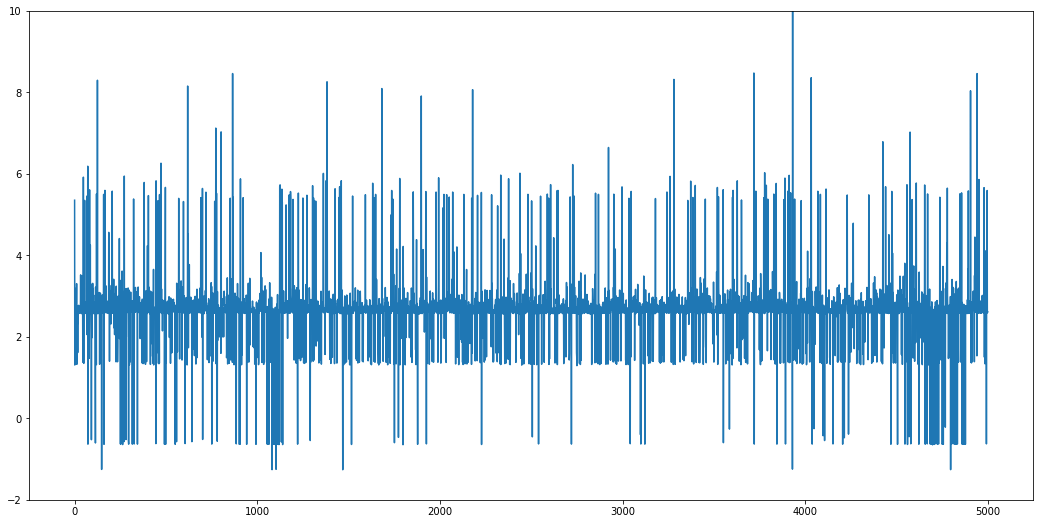

In [26]:
plt.figure(figsize=(18,9))
plt.plot(episode_scores[10000:])
plt.ylim(-2, 10)
plt.show()

In [25]:
# Save trained  Actor and Critic network weights 
torch.save(agent.actor_local.state_dict(),  "ddpgActor.pth")
torch.save(agent.critic_local.state_dict(), "ddpgCritic.pth")